In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from mixedbridge.stochastic_processes.bases import ContinuousTimeProcess
from mixedbridge.stochastic_processes.wiener import WienerProcess
from mixedbridge.solvers.sde import Euler

**$\mathbb{P}$: OU process**
$$
\mathrm{d}X_t = -\gamma\cdot X_t\mathrm{d}t + \sigma\mathrm{d}W_t
$$
**$\mathbb{P}^*$: OU Bridge**
$$
\mathrm{d}X^*_t = \left\{ -\gamma\cdot X_t + \frac{4\gamma^2e^{-\gamma(T-t)}(X^*_t\cdot e^{-\gamma(T-t)} - X_T)}{e^{-2\gamma(T-t)} - 1}\right\}\mathrm{d}t + \sigma\mathrm{d}W_t
$$
**$\mathbb{P}^\circ$: Brownian bridge**
$$
\mathrm{d}X^\circ_t = \frac{X_T-X^\circ_t}{T-t}\mathrm{d}t + \sigma\mathrm{d}W_t
$$
**$\mathbb{P}^\diamond$: Brownian bridge + NN**
$$
\mathrm{d}X^\diamond_t = \left\{\frac{X_T-X^\diamond_t}{T-t} + \sigma\cdot\nu_\theta(t, X^\diamond_t)\right\}\mathrm{d}t + \sigma\mathrm{d}W_t
$$
Set $\sigma=\gamma=1$

**With closed-form scores**

The optimal value of $\nu_\theta(t, x)$ should be $\nabla_x\log\frac{p(t, x;T, x_T)}{\tilde{p}(t, x;T, x_T)}$. Find that:
$$
\nabla_x\log p(t, x;T, x_T) = \frac{4\gamma^2e^{-\gamma(T-t)}(x\cdot e^{-\gamma(T-t)} - x_T)}{\sigma^2(e^{-2\gamma(T-t)} - 1)}
$$
and
$$
\nabla_x\log \tilde{p}(t, x;T, x_T) = \frac{x_T - x}{\sigma^2(T-t)}
$$

In [2]:
dim = 1
dtype = jnp.float32

sigma = 1.0
gamma = 1.0
T = 1.0
dt = 1e-2
x0 = jnp.array([0.0])
xT = jnp.array([1.0])

In [3]:
class OUProcess(ContinuousTimeProcess):
    
    def __init__(self, T, dt, dim, dtype, gamma, sigma):
        super().__init__(T, dt, dim, dtype)
        self.gamma = gamma
        self.sigma = sigma
    
    def f(self, t, x):
        return - self.gamma * x

    def g(self, t, x):
        return self.sigma * jnp.eye(self.dim, dtype=self.dtype)
    
    def Sigma(self, t, x):
        return self.sigma**2 * jnp.eye(self.dim, dtype=self.dtype)
    
    def inv_Sigma(self, t, x):
        return 1.0 / self.sigma**2 * jnp.eye(self.dim, dtype=self.dtype)
    
class OUBridgeProcess(ContinuousTimeProcess):
    
    def __init__(self, T, dt, dim, dtype, gamma, sigma, xT):
        super().__init__(T, dt, dim, dtype)
        self.gamma = gamma
        self.sigma = sigma
        self.xT = xT
    def f(self, t, x):
        return - self.gamma * x + \
            4.0 * self.gamma**2 * jnp.exp(- self.gamma * (self.T - t)) \
                * (x * jnp.exp(- self.gamma * (self.T - t)) - self.xT) / (jnp.exp(-2.0 * self.gamma * (self.T - t)) - 1.0)

    def g(self, t, x):
        return self.sigma * jnp.eye(self.dim, dtype=self.dtype)
    
    def Sigma(self, t, x):
        return self.sigma**2 * jnp.eye(self.dim, dtype=self.dtype)
    
    def inv_Sigma(self, t, x):
        return 1.0 / self.sigma**2 * jnp.eye(self.dim, dtype=self.dtype)
    
class BrownianBridgeProcess(ContinuousTimeProcess):
    
    def __init__(self, T, dt, dim, dtype, sigma, xT):
        super().__init__(T, dt, dim, dtype)
        self.sigma = sigma
        self.xT = xT

    def f(self, t, x):
        return (self.xT - x) / (self.T - t)

    def g(self, t, x):
        return self.sigma * jnp.eye(self.dim, dtype=self.dtype)

    def Sigma(self, t, x):
        return self.sigma**2 * jnp.eye(self.dim, dtype=self.dtype)
    
    def inv_Sigma(self, t, x):
        return 1.0 / self.sigma**2 * jnp.eye(self.dim, dtype=self.dtype)
    
    
class BrownianMixedBridgeProcess(ContinuousTimeProcess):
    
    def __init__(self, T, dt, dim, dtype, sigma, nu, xT):
        super().__init__(T, dt, dim, dtype)
        self.sigma = sigma      
        self.nu = nu
        self.xT = xT
    
    def f(self, t, x):
        return (self.xT - x) / (self.T - t) + self.sigma * jnp.eye(self.dim, dtype=self.dtype) @ self.nu(t, x)

    def g(self, t, x):
        return self.sigma * jnp.eye(self.dim, dtype=self.dtype)
    
    def Sigma(self, t, x):
        return self.sigma**2 * jnp.eye(self.dim, dtype=self.dtype)
    
    def inv_Sigma(self, t, x):
        return 1.0 / self.sigma**2 * jnp.eye(self.dim, dtype=self.dtype)
    

In [4]:
def score_p(t, x):
    return 4.0 * gamma**2 * jnp.exp(-gamma * (T - t)) * (x * jnp.exp(-gamma * (T - t)) - xT) \
        / (jnp.exp(-2.0 * gamma * (T - t)) - 1.0) * sigma**2

def score_p_tilde(t, x):
    return (xT - x) / ((T - t) * sigma**2)

def optimal_nu(t, x):
    return sigma * (score_p(t, x) - score_p_tilde(t, x))

In [5]:
key = jax.random.PRNGKey(42)
wiener_process = WienerProcess(dim=dim, dtype=dtype)
ou_sde = OUProcess(T=T, dt=dt, dim=dim, dtype=dtype, gamma=gamma, sigma=sigma)
ou_bridge_sde = OUBridgeProcess(T=T, dt=dt, dim=dim, dtype=dtype, gamma=gamma, sigma=sigma, xT=xT)
brownian_bridge_sde = BrownianBridgeProcess(T=T, dt=dt, dim=dim, dtype=dtype, sigma=sigma, xT=xT)

In [6]:
ou_solver = Euler(ou_sde, wiener_process)
ou_bridge_solver = Euler(ou_bridge_sde, wiener_process)
brownian_bridge_solver = Euler(brownian_bridge_sde, wiener_process)

In [7]:
n_batches = 64
key1, key2 = jax.random.split(key)
ou_bridge_path = ou_bridge_solver.solve(x0=x0, dWs=None, rng_key=key1, n_batches=n_batches)
brownian_bridge_path = brownian_bridge_solver.solve(x0=x0, dWs=None, rng_key=key2, n_batches=n_batches)

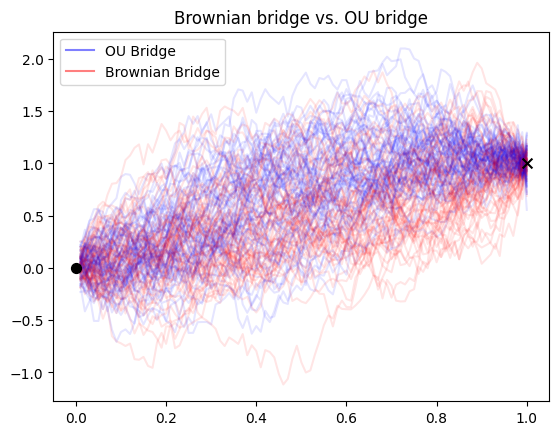

In [8]:
for i in range(n_batches):
    plt.plot(ou_bridge_path.ts, ou_bridge_path.xs[i, :, 0], color="blue", alpha=0.1)
    plt.plot(brownian_bridge_path.ts, brownian_bridge_path.xs[i, :, 0], color="red", alpha=0.1)
plt.scatter(0.0, x0, marker="o", color="black", s=50, zorder=10)
plt.scatter(T, xT, marker="x", color="black", s=50, zorder=10)
plt.title("Brownian bridge vs. OU bridge")

plt.plot([], [], color="blue", label="OU Bridge", alpha=0.5)
plt.plot([], [], color="red", label="Brownian Bridge", alpha=0.5)
plt.legend()


**Set up a NN**

In [9]:
from flax import linen as nn
from flax.training import train_state
import optax

In [10]:
# a very simple MLP
class MLP(nn.Module):

    @nn.compact
    def __call__(self, t, x):
        t = jnp.expand_dims(t, axis=-1)
        x = jnp.concatenate([t, x], axis=-1)
        x = nn.Dense(20)(x)
        x = nn.swish(x)
        x = nn.Dense(20)(x)
        x = nn.swish(x)
        x = nn.Dense(20)(x)
        x = nn.swish(x)
        x = nn.Dense(1)(x)
        return x

In [11]:
model = MLP()
dummy_t, dummy_x = jnp.zeros((1, )), jnp.zeros((1, 1))
key3, key4 = jax.random.split(key2)
params = model.init(key3, dummy_t, dummy_x)

In [12]:
def nu(t, x):
    return model.apply(params, t, x)

In [13]:
brownian_mixed_bridge = BrownianMixedBridgeProcess(T=T, dt=dt, dim=dim, dtype=dtype, sigma=sigma, nu=nu, xT=xT)
brownian_mixed_bridge_solver = Euler(brownian_mixed_bridge, wiener_process)
brownian_mixed_bridge_path = brownian_mixed_bridge_solver.solve(x0=x0, dWs=None, rng_key=key4, n_batches=n_batches)

Text(0.5, 1.0, 'Brownian mixed bridge with randomly initialized neural network')

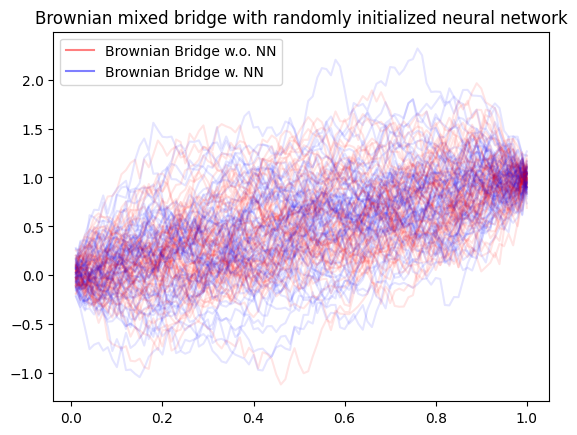

In [14]:
for i in range(n_batches):
    plt.plot(brownian_bridge_path.ts, brownian_bridge_path.xs[i, :, 0], color="red", alpha=0.1)
    plt.plot(brownian_bridge_path.ts, brownian_mixed_bridge_path.xs[i, :, 0], color="blue", alpha=0.1)
    
plt.plot([], [], color="red", label="Brownian Bridge w.o. NN", alpha=0.5)
plt.plot([], [], color="blue", label="Brownian Bridge w. NN", alpha=0.5)
plt.legend()
plt.title("Brownian mixed bridge with randomly initialized neural network")

In [15]:
def train_model(rng_key, model, path_solver, n_epochs, batch_size, train_with_true_score=False):
    rng_key, init_key = jax.random.split(rng_key)
    
    dummy_t, dummy_x = jnp.zeros((1, )), jnp.zeros((1, 1))
    params = model.init(init_key, dummy_t, dummy_x)
    optimizer = optax.adam(1e-2)
    
    model_state = train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optimizer
    )

    def sample_path(rng_key, path_solver):
        path = path_solver.solve(x0=x0, dWs=None, rng_key=rng_key, n_batches=batch_size)
        ts, xs = path.ts, path.xs
        ts = jnp.tile(jnp.expand_dims(ts, axis=0), reps=(batch_size, 1))
        return ts, xs
    
    def compute_loss_true(state, params, ts, xs):
        nus = state.apply_fn(params, ts, xs)
        norm = jnp.linalg.norm(nus[:, :-1] + (jnp.broadcast_to(xT, xs[:, :-1].shape) - xs[:, :-1]) / jnp.expand_dims((T - ts[:, :-1]), axis=-1) / sigma, axis=-2)
        norm = 0.5 * jnp.sum(norm**2, axis=1) * dt
        bs = jax.vmap(jax.vmap(score_p))(ts, xs)[:, :-1]
        prod = jax.vmap(jax.vmap(jnp.inner))(bs, nus[:, :-1])
        prod = jnp.sum(prod, axis=1) * dt
        return (norm - prod).mean(axis=0)
    
    def compute_loss(state, params, ts, xs):
        nus = state.apply_fn(params, ts, xs)
        norm = jnp.linalg.norm(nus[:, :-1] + (jnp.broadcast_to(xT, xs[:, :-1].shape) - xs[:, :-1]) / jnp.expand_dims((T - ts[:, :-1]), axis=-1) / sigma, axis=-2)
        norm = 0.5 * jnp.sum(norm**2, axis=1) * dt
        bs = (jnp.diff(xs, axis=1) - jax.vmap(jax.vmap(ou_bridge_sde.f))(ts[:, :-1], xs[:, :-1]) * dt) / sigma
        prod = jax.vmap(jax.vmap(jnp.inner))(bs, nus[:, :-1])
        prod = jnp.sum(prod, axis=1) * dt
        return (norm - prod).mean(axis=0)
    
    @jax.jit
    def train_step(state, ts, xs):
        loss_fn = compute_loss_true if train_with_true_score else compute_loss
        grad_fn = jax.value_and_grad(loss_fn, argnums=1, has_aux=False)
        loss, grads = grad_fn(state, state.params, ts, xs)
        state = state.apply_gradients(grads=grads)
        return state, loss
    
    for epoch in range(1, n_epochs + 1):
        rng_key, batch_key = jax.random.split(rng_key)
        ts, xs = sample_path(batch_key, path_solver)
        model_state, loss = train_step(model_state, ts, xs)
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, loss: {loss}")
    return model_state

In [16]:
model = MLP()
n_epochs = 3000
batch_size = 64

In [17]:
# train with true score
model_state_true = train_model(key, model, brownian_bridge_solver, n_epochs, batch_size, train_with_true_score=True)

Epoch 100, loss: 0.31034570932388306
Epoch 200, loss: 0.15284129977226257
Epoch 300, loss: -0.28143689036369324
Epoch 400, loss: -0.34735462069511414
Epoch 500, loss: -0.44299978017807007
Epoch 600, loss: -0.6788479089736938
Epoch 700, loss: -0.27543556690216064
Epoch 800, loss: 0.009724542498588562
Epoch 900, loss: -0.4901699423789978
Epoch 1000, loss: -0.5235258936882019
Epoch 1100, loss: -0.3328123390674591
Epoch 1200, loss: -0.5768500566482544
Epoch 1300, loss: -0.39194101095199585
Epoch 1400, loss: -0.5984789729118347
Epoch 1500, loss: -0.5922442674636841
Epoch 1600, loss: -0.437544047832489
Epoch 1700, loss: -0.48810672760009766
Epoch 1800, loss: -0.6837884187698364
Epoch 1900, loss: -0.6994645595550537
Epoch 2000, loss: -0.5817197561264038
Epoch 2100, loss: -0.5930315256118774
Epoch 2200, loss: -0.37585240602493286
Epoch 2300, loss: -0.4703175127506256
Epoch 2400, loss: -0.32903456687927246
Epoch 2500, loss: -0.45323705673217773
Epoch 2600, loss: -0.4555802345275879
Epoch 2700, 

In [18]:
def nu_true_learned(t, x):
    return model_state_true.apply_fn(model_state_true.params, t, x)

In [19]:
key5, key6 = jax.random.split(key4)
brownian_mixed_bridge_true_learned = BrownianMixedBridgeProcess(T=T, dt=dt, dim=dim, dtype=dtype, sigma=sigma, nu=nu_true_learned, xT=xT)
brownian_mixed_bridge_true_learned_solver = Euler(brownian_mixed_bridge_true_learned, wiener_process)
brownian_mixed_bridge_true_learned_path = brownian_mixed_bridge_true_learned_solver.solve(x0=x0, dWs=None, rng_key=key5, n_batches=n_batches)

brownian_mixed_bridge_true = BrownianMixedBridgeProcess(T=T, dt=dt, dim=dim, dtype=dtype, sigma=sigma, nu=optimal_nu, xT=xT)
brownian_mixed_bridge_true_solver = Euler(brownian_mixed_bridge_true, wiener_process)
brownian_mixed_bridge_true_path = brownian_mixed_bridge_true_solver.solve(x0=x0, dWs=None, rng_key=key5, n_batches=n_batches)

ou_bridge_path = ou_bridge_solver.solve(x0=x0, dWs=None, rng_key=key5, n_batches=n_batches)

Text(0.5, 1.0, 'Brownian mixed bridge with trained neural network vs. truth')

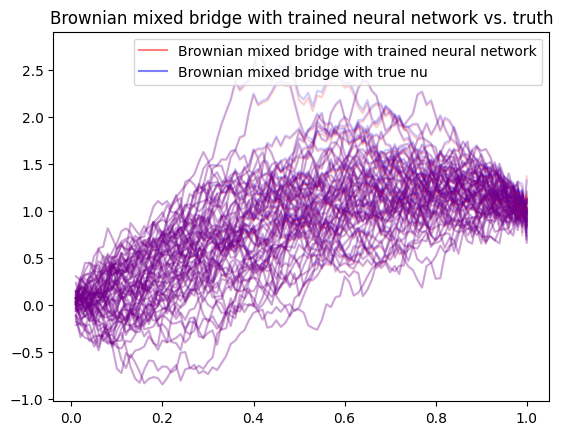

In [20]:
for i in range(n_batches):
    plt.plot(brownian_mixed_bridge_true_learned.ts[1:], brownian_mixed_bridge_true_learned_path.xs[i, :, 0], color="red", alpha=0.2)
    plt.plot(brownian_mixed_bridge_true.ts[1:], brownian_mixed_bridge_true_path.xs[i, :, 0], color="blue", alpha=0.2)
    
plt.plot([], [], color="red", label="Brownian mixed bridge with trained neural network", alpha=0.5)
plt.plot([], [], color="blue", label="Brownian mixed bridge with true nu", alpha=0.5)
plt.legend()
plt.title("Brownian mixed bridge with trained neural network vs. truth")

In [21]:
model = MLP()
n_epochs = 3000
batch_size = 64

In [22]:
# train with estimated score
model_state_estimated = train_model(key, model, brownian_bridge_solver, n_epochs, batch_size, train_with_true_score=False)

Epoch 100, loss: 0.7524476051330566
Epoch 200, loss: 0.28933075070381165
Epoch 300, loss: 0.21405161917209625
Epoch 400, loss: 0.07272318005561829
Epoch 500, loss: 0.024530738592147827
Epoch 600, loss: 0.04783836007118225
Epoch 700, loss: 0.010600339621305466
Epoch 800, loss: 0.0018693888559937477
Epoch 900, loss: -0.027367880567908287
Epoch 1000, loss: -0.007361580617725849
Epoch 1100, loss: 0.03095225989818573
Epoch 1200, loss: -0.035246673971414566
Epoch 1300, loss: -0.05384565144777298
Epoch 1400, loss: -0.023413274437189102
Epoch 1500, loss: 0.0005781130748800933
Epoch 1600, loss: -0.02568696066737175
Epoch 1700, loss: 0.395976722240448
Epoch 1800, loss: -0.001603499986231327
Epoch 1900, loss: -0.014248063787817955
Epoch 2000, loss: -0.025464022532105446
Epoch 2100, loss: -0.010835577733814716
Epoch 2200, loss: -0.01921994425356388
Epoch 2300, loss: -0.04942341893911362
Epoch 2400, loss: -0.03230781853199005
Epoch 2500, loss: -0.054336465895175934
Epoch 2600, loss: -0.025558777153

In [23]:
def nu_estimated_learned(t, x):
    return model_state_estimated.apply_fn(model_state_estimated.params, t, x)

In [24]:
brownian_mixed_bridge_learned = BrownianMixedBridgeProcess(T=T, dt=dt, dim=dim, dtype=dtype, sigma=sigma, nu=nu_estimated_learned, xT=xT)
brownian_mixed_bridge_learned_solver = Euler(brownian_mixed_bridge_learned, wiener_process)
brownian_mixed_bridge_learned_path = brownian_mixed_bridge_learned_solver.solve(x0=x0, dWs=None, rng_key=key5, n_batches=n_batches)

Text(0.5, 1.0, 'Brownian mixed bridge with trained neural network vs. true nu')

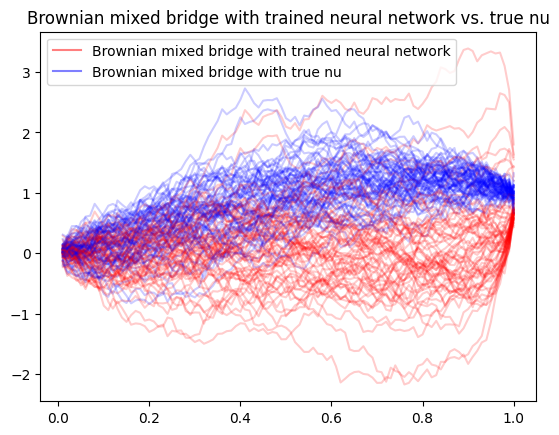

In [25]:
for i in range(n_batches):
    plt.plot(brownian_mixed_bridge_learned.ts[1:], brownian_mixed_bridge_learned_path.xs[i, :, 0], color="red", alpha=0.2)
    plt.plot(brownian_mixed_bridge_true.ts[1:], brownian_mixed_bridge_true_path.xs[i, :, 0], color="blue", alpha=0.2)

plt.plot([], [], color="red", label="Brownian mixed bridge with trained neural network", alpha=0.5)
plt.plot([], [], color="blue", label="Brownian mixed bridge with true nu", alpha=0.5)
plt.legend()
plt.title("Brownian mixed bridge with trained neural network vs. true nu")